In [1]:
import numpy as np
import os
import librosa
import librosa.display as dis
import time
import matplotlib.pyplot as plt

from config import DATASET_DIR_PATH

In [2]:
# duration = 0
# filename = []
# for root, subdr, files in os.walk(DATASET_DIR_PATH):
#     for file in files:
#         if file.endswith(".wav"):
#             name = os.path.join(root, file)
#             length = librosa.get_duration(filename=name)
#             if length > 5:
#                 duration = length
#                 filename.append(file)
# print(duration)
# print(len(filename))

In [3]:
# RAVDESS native sample rate is 48k
SAMPLE_RATE = 48000

def get_waveforms(path):
    """
    load all audio file from path
    load full 5 seconds of the audio file; nativve sample rate = 48k
    """
    waveforms = [] # waveforms to augment later
    emotions = []  # emotion labels
    file_count = 0
    
    for root, subdr, files in os.walk(path):
        for file in files:
            X, _ = librosa.load(os.path.join(root, file), duration=3, offset=0.5, res_type='kaiser_fast', sr=SAMPLE_RATE)

            waveform = np.zeros((SAMPLE_RATE*3,))
            waveform[:len(X)] = X

            # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
            # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
            label = int(file[7:8]) - 1

            waveforms.append(waveform)
            emotions.append(label)

            file_count += 1
            # keep track of data loader's progress
            print('\r'+f' Processed {file_count}/{5252} audio samples',end='')

    return waveforms, emotions


def get_features(waveforms):
    features = []
    file_count = 0
    
    for waveform in waveforms:
        mfccs = librosa.feature.mfcc(waveform,
                                     sr=SAMPLE_RATE,
                                     n_mfcc=40,
                                     n_fft=1024,
                                     win_length=512,
                                     window='hamming',
                                     n_mels=128,
                                     fmax=SAMPLE_RATE/2)
        features.append(mfccs)
        file_count += 1
        # print progress 
        print('\r'+f' Processed {file_count}/{len(waveforms)} waveforms',end='')

    return features

In [4]:
# load data 
# init explicitly to prevent data leakage from past sessions
# RAVDESS - 1440 speech + 1012 song
# TESS - 2800 speech
# TOTAL - 1440 + 1012 + 2800 = 5252

waveforms, emotions = [], []
waveforms, emotions = get_waveforms(path=DATASET_DIR_PATH)

 Processed 5252/5252 audio samples

In [5]:
print(f'Waveforms set: {len(waveforms)} samples')
# we have 1440 waveforms but we need to know their length too; should be 5 sec * 48k = 240k
print(f'Waveform signal length: {len(waveforms[0])}')
print(f'Emotions set: {len(emotions)} sample labels')

Waveforms set: 5252 samples
Waveform signal length: 144000
Emotions set: 5252 sample labels


In [6]:
emotions_dict ={
    '0':'neutral',
    '1':'calm',
    '2':'happy',
    '3':'sad',
    '4':'angry',
    '5':'fearful',
    '6':'disgust',
    '7':'surprised'
}

In [7]:
# create storage for train, validation, test sets and their indices
train_set,valid_set,test_set = [],[],[]
X_train,X_valid,X_test = [],[],[]
y_train,y_valid,y_test = [],[],[]

# convert waveforms to array for processing
waveforms = np.array(waveforms)

# process each emotion separately to make sure we build balanced train/valid/test sets 
for emotion_num in range(len(emotions_dict)):
        
    # find all indices of a single unique emotion
    emotion_indices = [index for index, emotion in enumerate(emotions) if emotion==emotion_num]

    # seed for reproducibility 
    np.random.seed(69)
    # shuffle indicies 
    emotion_indices = np.random.permutation(emotion_indices)

    # store dim (length) of the emotion list to make indices
    dim = len(emotion_indices)

    # store indices of training, validation and test sets in 80/10/10 proportion
    # train set is first 80%
    train_indices = emotion_indices[:int(0.8*dim)]
    # validation set is next 10% (between 80% and 90%)
    valid_indices = emotion_indices[int(0.8*dim):int(0.9*dim)]
    # test set is last 10% (between 90% - end/100%)
    test_indices = emotion_indices[int(0.9*dim):]

    # create train waveforms/labels sets
    X_train.append(waveforms[train_indices,:])
    y_train.append(np.array([emotion_num]*len(train_indices),dtype=np.int32))
    # create validation waveforms/labels sets
    X_valid.append(waveforms[valid_indices,:])
    y_valid.append(np.array([emotion_num]*len(valid_indices),dtype=np.int32))
    # create test waveforms/labels sets
    X_test.append(waveforms[test_indices,:])
    y_test.append(np.array([emotion_num]*len(test_indices),dtype=np.int32))

    # store indices for each emotion set to verify uniqueness between sets 
    train_set.append(train_indices)
    valid_set.append(valid_indices)
    test_set.append(test_indices)

# concatenate, in order, all waveforms back into one array 
X_train = np.concatenate(X_train,axis=0)
X_valid = np.concatenate(X_valid,axis=0)
X_test = np.concatenate(X_test,axis=0)

# concatenate, in order, all emotions back into one array 
y_train = np.concatenate(y_train,axis=0)
y_valid = np.concatenate(y_valid,axis=0)
y_test = np.concatenate(y_test,axis=0)

# combine and store indices for all emotions' train, validation, test sets to verify uniqueness of sets
train_set = np.concatenate(train_set,axis=0)
valid_set = np.concatenate(valid_set,axis=0)
test_set = np.concatenate(test_set,axis=0)

# check shape of each set
print(f'Training waveforms:{X_train.shape}, y_train:{y_train.shape}')
print(f'Validation waveforms:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'Test waveforms:{X_test.shape}, y_test:{y_test.shape}')

# make sure train, validation, test sets have no overlap/are unique
# get all unique indices across all sets and how many times each index appears (count)
uniques, count = np.unique(np.concatenate([train_set,test_set,valid_set],axis=0), return_counts=True)

# if each index appears just once, and we have 1440 such unique indices, then all sets are unique
if sum(count==1) == len(emotions):
    print(f'\nSets are unique: {sum(count==1)} samples out of {len(emotions)} are unique')
else:
    print(f'\nSets are NOT unique: {sum(count==1)} samples out of {len(emotions)} are unique')

Training waveforms:(4196, 144000), y_train:(4196,)
Validation waveforms:(527, 144000), y_valid:(527,)
Test waveforms:(529, 144000), y_test:(529,)

Sets are unique: 5252 samples out of 5252 are unique


In [8]:
# We extract MFCC features from waveforms and store in respective 'features' array

print('Train waveforms:') # get training set features 
features_train = get_features(X_train)

print('\n\nValidation waveforms:') # get validation set features
features_valid = get_features(X_valid)

print('\n\nTest waveforms:') # get test set features 
features_test = get_features(X_test)

print(f'\n\nFeatures set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'Features (MFC coefficient matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
 Processed 4196/4196 waveforms

Validation waveforms:
 Processed 527/527 waveforms

Test waveforms:
 Processed 529/529 waveforms

Features set: 5252 total, 4196 train, 527 validation, 529 test samples
Features (MFC coefficient matrix) shape: 40 mel frequency coefficients x 282 time steps


## Augmenting the Data with AWGN - Additive White Gaussian Noise

### Motivation

Since our dataset is small, it is prone to overfitting - especially with highly parameterized deep neural net models such as the one we aim to build in this notebook. As such, we're going to want to augment our data. Generating more real samples will be immensely difficult. Instead, we can add white noise to the audio signals - not only to mask the effect of random noise present in the training set - but also to create pseudo-new training samples and offset the impact of noise intrinsic to the dataset.

In addition, the RAVDESS dataset is extremely clean - we will likely want to make predictions on noisy, real-world data - yet another reason to augment the training data.

We're going to use Additive White Gaussian Noise (AWGN). It's Additive because we're adding it to the source audio signal, it's Gaussian because the noise vector will be sampled from a normal distribution and have a time average of zero (zero-mean), and it's white because after a whitening transformation the noise will add power to the audio signal uniformly across the frequency distribution.

We need a good balance of noise - too little will be useless, and too much will make it too difficult for the network to learn from the training data. Note that this is just for training - we would not need to add AWGN to real-world data on which we make predictions (although we could).

## Math

The key parameters in AWGN are the signal to noise ratio (SNR), defining the magnitude of the noise added w.r.t. the audio signal. We parameterize AWGN with the minimum and maximize SNR so we can pick a random SNR to use in augmenting each sample's waveform.

We need to constrain covariance to make it true AWGN. We make a zero-mean vector of Gaussian noises (np.random.normal) that are statistically dependent. We need to apply a whitening transformation, a linear transformation taking a vector of random normal (Gaussian) variables with a known covariance matrix and mapping it to a new vector whose covariance is the identity matrix, i.e. the vector is now perfectly uncorrelated with a diaganol covariance matrix, each point of noise having variance == stdev == 1. The whitening transformation by definition transforms a vector into a white noise vector.

We're going to add the AWGN augmented waveforms as new samples to our dataset. Since we generate AWGN which is random for each and every sample - random random noise - we can add multiples of our noise-augmented dataset. I'll add 2 extra identical, randomly noisy datasets with 5252 samples each to get a dataset with 5252 native + 5252x2 = 15756 noisy samples.

In [9]:
def awgn_augmentation(waveform, multiples=2, bits=16, snr_min=15, snr_max=30): 
    
    # get length of waveform (should be 3*48k = 144k)
    wave_len = len(waveform)
    
    # Generate normally distributed (Gaussian) noises
    # one for each waveform and multiple (i.e. wave_len*multiples noises)
    noise = np.random.normal(size=(multiples, wave_len))
    
    # Normalize waveform and noise
    norm_constant = 2.0**(bits-1)
    norm_wave = waveform / norm_constant
    norm_noise = noise / norm_constant
    
    # Compute power of waveform and power of noise
    signal_power = np.sum(norm_wave ** 2) / wave_len
    noise_power = np.sum(norm_noise ** 2, axis=1) / wave_len
    
    # Choose random SNR in decibels in range [15,30]
    snr = np.random.randint(snr_min, snr_max)
    
    # Apply whitening transformation: make the Gaussian noise into Gaussian white noise
    # Compute the covariance matrix used to whiten each noise 
    # actual SNR = signal/noise (power)
    # actual noise power = 10**(-snr/10)
    covariance = np.sqrt((signal_power / noise_power) * 10 ** (- snr / 10))
    # Get covariance matrix with dim: (144000, 2) so we can transform 2 noises: dim (2, 144000)
    covariance = np.ones((wave_len, multiples)) * covariance

    # Since covariance and noise are arrays, * is the haddamard product 
    # Take Haddamard product of covariance and noise to generate white noise
    multiple_augmented_waveforms = waveform + covariance.T * noise
    
    return multiple_augmented_waveforms


In [10]:
def augment_waveforms(waveforms, features, emotions, multiples):
    # keep track of how many waveforms we've processed so we can add correct emotion label in the same order
    emotion_count = 0
    # keep track of how many augmented samples we've added
    added_count = 0
    # convert emotion array to list for more efficient appending
    emotions = emotions.tolist()

    for waveform in waveforms:

        # Generate 2 augmented multiples of the dataset, i.e. 1440 native + 1440*2 noisy = 4320 samples total
        augmented_waveforms = awgn_augmentation(waveform, multiples=multiples)

        # compute spectrogram for each of 2 augmented waveforms
        for augmented_waveform in augmented_waveforms:

            # Compute MFCCs over augmented waveforms
            augmented_mfcc = librosa.feature.mfcc(waveform,
                                                  sr=SAMPLE_RATE,
                                                  n_mfcc=40,
                                                  n_fft=1024,
                                                  win_length=512,
                                                  window='hamming',
                                                  n_mels=128,
                                                  fmax=SAMPLE_RATE/2)

            # append the augmented spectrogram to the rest of the native data
            features.append(augmented_mfcc)
            emotions.append(emotions[emotion_count])

            # keep track of new augmented samples
            added_count += 1

            # check progress
            print('\r'+f'Processed {emotion_count + 1}/{len(waveforms)} waveforms for {added_count}/{len(waveforms)*multiples} new augmented samples',end='')

        # keep track of the emotion labels to append in order
        emotion_count += 1
        
        # store augmented waveforms to check their shape
        augmented_waveforms_temp.append(augmented_waveforms)
    
    return features, emotions

## Compute AWGN-augmented features and add to the rest of the dataset

In [11]:
# store augmented waveforms to verify their shape and random-ness
augmented_waveforms_temp = []

# specify multiples of our dataset to add as augmented data
multiples = 2

print('Train waveforms:') # augment waveforms of training set
features_train , y_train = augment_waveforms(X_train, features_train, y_train, multiples)

print('\n\nValidation waveforms:') # augment waveforms of validation set
features_valid, y_valid = augment_waveforms(X_valid, features_valid, y_valid, multiples)

print('\n\nTest waveforms:') # augment waveforms of test set 
features_test, y_test = augment_waveforms(X_test, features_test, y_test, multiples)

# Check new shape of extracted features and data:
print(f'\n\nNative + Augmented Features set: {len(features_train)+len(features_test)+len(features_valid)} total, {len(features_train)} train, {len(features_valid)} validation, {len(features_test)} test samples')
print(f'{len(y_train)} training sample labels, {len(y_valid)} validation sample labels, {len(y_test)} test sample labels')
print(f'Features (MFCC matrix) shape: {len(features_train[0])} mel frequency coefficients x {len(features_train[0][1])} time steps')

Train waveforms:
Processed 4196/4196 waveforms for 8392/8392 new augmented samples

Validation waveforms:
Processed 527/527 waveforms for 1054/1054 new augmented samples

Test waveforms:
Processed 529/529 waveforms for 1058/1058 new augmented samples

Native + Augmented Features set: 15756 total, 12588 train, 1581 validation, 1587 test samples
12588 training sample labels, 1581 validation sample labels, 1587 test sample labels
Features (MFCC matrix) shape: 40 mel frequency coefficients x 282 time steps


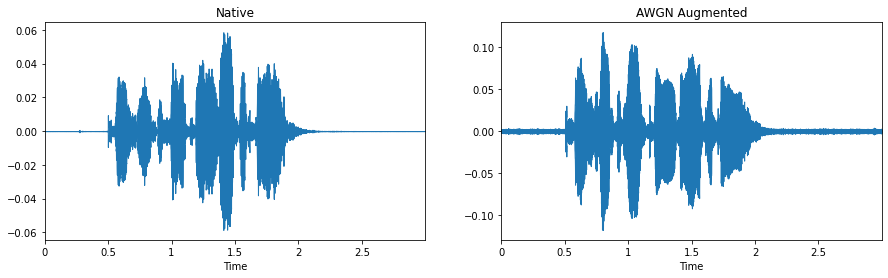

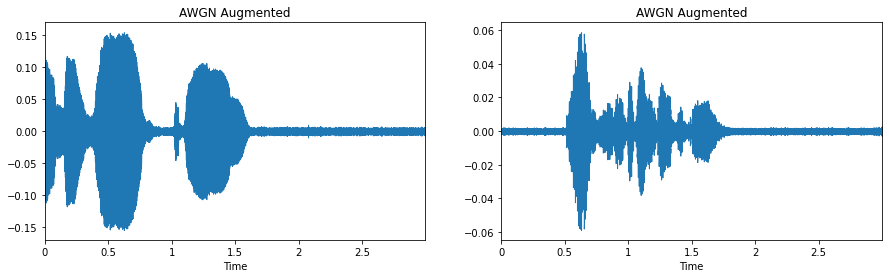

In [12]:
# pick a random waveform, but same one from native and augmented set for easier comparison
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveplot(waveforms[12], sr=SAMPLE_RATE)
plt.title('Native')

plt.subplot(1, 2, 2)
# augmented waveforms are 2D len 1440 list with 2 waveforms in each position
librosa.display.waveplot(augmented_waveforms_temp[0][0], sr=SAMPLE_RATE)
plt.title('AWGN Augmented')
plt.show()

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
librosa.display.waveplot(augmented_waveforms_temp[12][0], sr=SAMPLE_RATE)
plt.title('AWGN Augmented')

plt.subplot(1, 2, 2)
librosa.display.waveplot(augmented_waveforms_temp[17][0], sr=SAMPLE_RATE)
plt.title('AWGN Augmented')
plt.show()

In [13]:
# need to make dummy input channel for CNN input feature tensor
X_train = np.expand_dims(features_train,1)
X_valid = np.expand_dims(features_valid, 1)
X_test = np.expand_dims(features_test,1)

# convert emotion labels from list back to numpy arrays for PyTorch to work with 
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# confiorm that we have tensor-ready 4D data array
# should print (batch, channel, width, height) == (4320, 1, 128, 282) when multiples==2
print(f'Shape of 4D feature array for input tensor: {X_train.shape} train, {X_valid.shape} validation, {X_test.shape} test')
print(f'Shape of emotion labels: {y_train.shape} train, {y_valid.shape} validation, {y_test.shape} test')

Shape of 4D feature array for input tensor: (12588, 1, 40, 282) train, (1581, 1, 40, 282) validation, (1587, 1, 40, 282) test
Shape of emotion labels: (12588,) train, (1581,) validation, (1587,) test


In [14]:
# free up some RAM - no longer need full feature set or any waveforms 
del features_train, features_valid, features_test, waveforms, augmented_waveforms_temp

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

#### Scale the training data ####
# store shape so we can transform it back 
N,C,H,W = X_train.shape
# Reshape to 1D because StandardScaler operates on a 1D array
# tell numpy to infer shape of 1D array with '-1' argument
X_train = np.reshape(X_train, (N,-1)) 
X_train = scaler.fit_transform(X_train)
# Transform back to NxCxHxW 4D tensor format
X_train = np.reshape(X_train, (N,C,H,W))

##### Scale the validation set ####
N,C,H,W = X_valid.shape
X_valid = np.reshape(X_valid, (N,-1))
X_valid = scaler.transform(X_valid)
X_valid = np.reshape(X_valid, (N,C,H,W))

#### Scale the test set ####
N,C,H,W = X_test.shape
X_test = np.reshape(X_test, (N,-1))
X_test = scaler.transform(X_test)
X_test = np.reshape(X_test, (N,C,H,W))

# check shape of each set again
print(f'X_train scaled:{X_train.shape}, y_train:{y_train.shape}')
print(f'X_valid scaled:{X_valid.shape}, y_valid:{y_valid.shape}')
print(f'X_test scaled:{X_test.shape}, y_test:{y_test.shape}')

X_train scaled:(12588, 1, 40, 282), y_train:(12588,)
X_valid scaled:(1581, 1, 40, 282), y_valid:(1581,)
X_test scaled:(1587, 1, 40, 282), y_test:(1587,)


In [16]:
###### SAVE #########
# choose save file name 
filename = 'features_labels.npy'

# open file in write mode and write data
with open(filename, 'wb') as f:
    np.save(f, X_train)
    np.save(f, X_valid)
    np.save(f, X_test)
    np.save(f, y_train)
    np.save(f, y_valid)
    np.save(f, y_test)

print(f'Features and labels saved to {filename}')

Features and labels saved to features_labels.npy
